In [1]:
%load_ext autoreload
import datetime
# import ete3
import itertools
import json
import logging
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import typing
# import re
import xml.etree.ElementTree as ET
# import xml.dom.minidom
# import xmlschema

In [2]:
%autoreload
from maxes.xes_loader2 import XesLoader, XesLog
# from maxes.xes_file import XesFile
# from maxes.analyze_xes import AnalyzeXes
# import maxes.analyze_sequence
# import maxes.serialization.serialize
# import maxes.graphs
import maxes.notebooks.utils
import maxes.utils

Config:
{'project_directory_path': '/vt/md/maxes/maxes', 'data_directory_path': '/vt/md/maxes/maxes/data'}


In [3]:
maxes.notebooks.utils.init_notebook() # RUN ONLY ONCE

Loading config from: C:\vt\md\maxes\maxes\config.local.yml
Config:
{'project_directory_path': '/vt/md/maxes/maxes', 'data_directory_path': '/vt/md/maxes/maxes/data'}


In [4]:
file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
log = maxes.notebooks.utils.load_xes(file_path)
log.df

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,location,duration,outcome
0,Brisbane,customer,1970-01-01 00:00:00+00:00,complete,incoming claim,NaN,NaN,NaN
1,NaN,Call Centre Agent Brisbane,1970-01-01 00:00:00+00:00,start,B check if sufficient information is available,Brisbane,NaN,NaN
2,NaN,Call Centre Agent Brisbane,1970-01-01 00:00:41+00:00,complete,B check if sufficient information is available,Brisbane,NaN,NaN
3,NaN,Call Centre Agent Brisbane,1970-01-01 00:00:41+00:00,start,B register claim,NaN,NaN,NaN
4,NaN,Call Centre Agent Brisbane,1970-01-01 00:12:59+00:00,complete,B register claim,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4,NaN,Call Centre Agent Sydney,1970-01-01 02:39:31+00:00,complete,S register claim,NaN,NaN,NaN
5,NaN,Claims handler,1970-01-01 06:56:04+00:00,start,determine likelihood of claim,NaN,NaN,NaN
6,NaN,Claims handler,1970-01-01 06:56:35+00:00,complete,determine likelihood of claim,NaN,NaN,NaN
7,NaN,Claims handler,1970-01-01 06:56:35+00:00,start,end,NaN,17306,not liable


In [5]:
%autoreload
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from maxes.generators.xes_generator.xes_generator3 import XesGenerator3, XesAttributeModelPredictor

model_prototype = Pipeline(steps=[
    ("column selector", ColumnTransformer([
        ("concept_name", OneHotEncoder(), ["concept:name"]),
        ("lifecycle_transition", OneHotEncoder(), ["lifecycle:transition"])
    ])),
    ("classifier", MLPClassifier())
])

xes_generator = XesGenerator3(
    attributes_models=[
        XesAttributeModelPredictor(
            attribute="org:resource",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="location",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="call centre",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="outcome",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        )
    ],
    traces_count=100
)
xes_generator.fit(log)

In [19]:
generated_log = xes_generator.generate()
generated_log._update_df()
generated_log.df

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome
0,incoming claim,complete,1970-01-01 07:30:32.356494+00:00,customer,Sydney,NaN,NaN
1,B check if sufficient information is available,start,1970-01-01 07:33:44.233730+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN
2,B check if sufficient information is available,complete,1970-01-01 07:34:14.005846+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN
3,B register claim,start,1970-01-01 07:34:14.504072+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN
4,B register claim,complete,1970-01-01 07:40:24.990310+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6,determine likelihood of claim,complete,1970-01-01 05:11:15.502970+00:00,Claims handler,NaN,NaN,NaN
7,assess claim,start,1970-01-01 05:11:17.296662+00:00,Claims handler,NaN,NaN,NaN
8,assess claim,complete,1970-01-01 05:23:23.540904+00:00,Claims handler,NaN,NaN,NaN
9,end,start,1970-01-01 05:23:23.261564+00:00,Claims handler,NaN,NaN,processed


In [20]:
# TODO: assign "case:concept:name" attribute to trace

for index, trace in enumerate(generated_log.traces):
    trace.attributes["concept:name"] = str(index)

generated_log._update_df()
generated_log.df

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome
0,incoming claim,complete,1970-01-01 07:30:32.356494+00:00,customer,Sydney,NaN,NaN
1,B check if sufficient information is available,start,1970-01-01 07:33:44.233730+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN
2,B check if sufficient information is available,complete,1970-01-01 07:34:14.005846+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN
3,B register claim,start,1970-01-01 07:34:14.504072+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN
4,B register claim,complete,1970-01-01 07:40:24.990310+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6,determine likelihood of claim,complete,1970-01-01 05:11:15.502970+00:00,Claims handler,NaN,NaN,NaN
7,assess claim,start,1970-01-01 05:11:17.296662+00:00,Claims handler,NaN,NaN,NaN
8,assess claim,complete,1970-01-01 05:23:23.540904+00:00,Claims handler,NaN,NaN,NaN
9,end,start,1970-01-01 05:23:23.261564+00:00,Claims handler,NaN,NaN,processed


In [21]:
generated_log.trace_attribute_type_map

{'concept:name': 'string', 'description': 'string'}

In [23]:
%autoreload

import os

from maxes.serialization.serialize import Serializer

generated_log_ET = Serializer().serialize(generated_log, xml_log_skeleton=log.loader.xml_log_skeleton)

ET.indent(generated_log_ET)
ET.register_namespace("", "http://www.xes-standard.org")

generated_log_path = os.path.join(maxes.notebooks.utils.get_project_path(), "output/simple_generated.xes")
with open(generated_log_path, "w") as file:
    generated_log_ET.write(file, encoding="unicode")

# PM4PY Analysis

In [8]:
import pm4py

log_pm4py = pm4py.read_xes(maxes.notebooks.utils.get_data_path("other/simple.xes"))
log_pm4py

parsing log, completed traces ::   0%|          | 0/3512 [00:00<?, ?it/s]

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,case:concept:name,case:description,location,duration,outcome
0,Brisbane,customer,1970-01-01 01:00:00+00:00,complete,incoming claim,0,Simulated process instance,NaN,NaN,NaN
1,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:00+00:00,start,B check if sufficient information is available,0,Simulated process instance,Brisbane,NaN,NaN
2,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:41+00:00,complete,B check if sufficient information is available,0,Simulated process instance,Brisbane,NaN,NaN
3,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:41+00:00,start,B register claim,0,Simulated process instance,NaN,NaN,NaN
4,NaN,Call Centre Agent Brisbane,1970-01-01 01:12:59+00:00,complete,B register claim,0,Simulated process instance,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
46133,NaN,Call Centre Agent Sydney,1970-01-01 03:39:31+00:00,complete,S register claim,999,Simulated process instance,NaN,NaN,NaN
46134,NaN,Claims handler,1970-01-01 07:56:04+00:00,start,determine likelihood of claim,999,Simulated process instance,NaN,NaN,NaN
46135,NaN,Claims handler,1970-01-01 07:56:35+00:00,complete,determine likelihood of claim,999,Simulated process instance,NaN,NaN,NaN
46136,NaN,Claims handler,1970-01-01 07:56:35+00:00,start,end,999,Simulated process instance,NaN,17306,not liable


In [24]:
generated_log_pm4py = pm4py.read_xes(generated_log_path)
generated_log_pm4py

parsing log, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,case:concept:name,location,outcome
0,incoming claim,complete,1970-01-01 07:30:32.356494+00:00,customer,Sydney,0,NaN,NaN
1,B check if sufficient information is available,start,1970-01-01 07:33:44.233730+00:00,Call Centre Agent Brisbane,NaN,0,Brisbane,NaN
2,B check if sufficient information is available,complete,1970-01-01 07:34:14.005846+00:00,Call Centre Agent Brisbane,NaN,0,Brisbane,NaN
3,B register claim,start,1970-01-01 07:34:14.504072+00:00,Call Centre Agent Brisbane,NaN,0,NaN,NaN
4,B register claim,complete,1970-01-01 07:40:24.990310+00:00,Call Centre Agent Brisbane,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...
1291,determine likelihood of claim,complete,1970-01-01 05:11:15.502970+00:00,Claims handler,NaN,99,NaN,NaN
1292,assess claim,start,1970-01-01 05:11:17.296662+00:00,Claims handler,NaN,99,NaN,NaN
1293,assess claim,complete,1970-01-01 05:23:23.540904+00:00,Claims handler,NaN,99,NaN,NaN
1294,end,start,1970-01-01 05:23:23.261564+00:00,Claims handler,NaN,99,NaN,processed


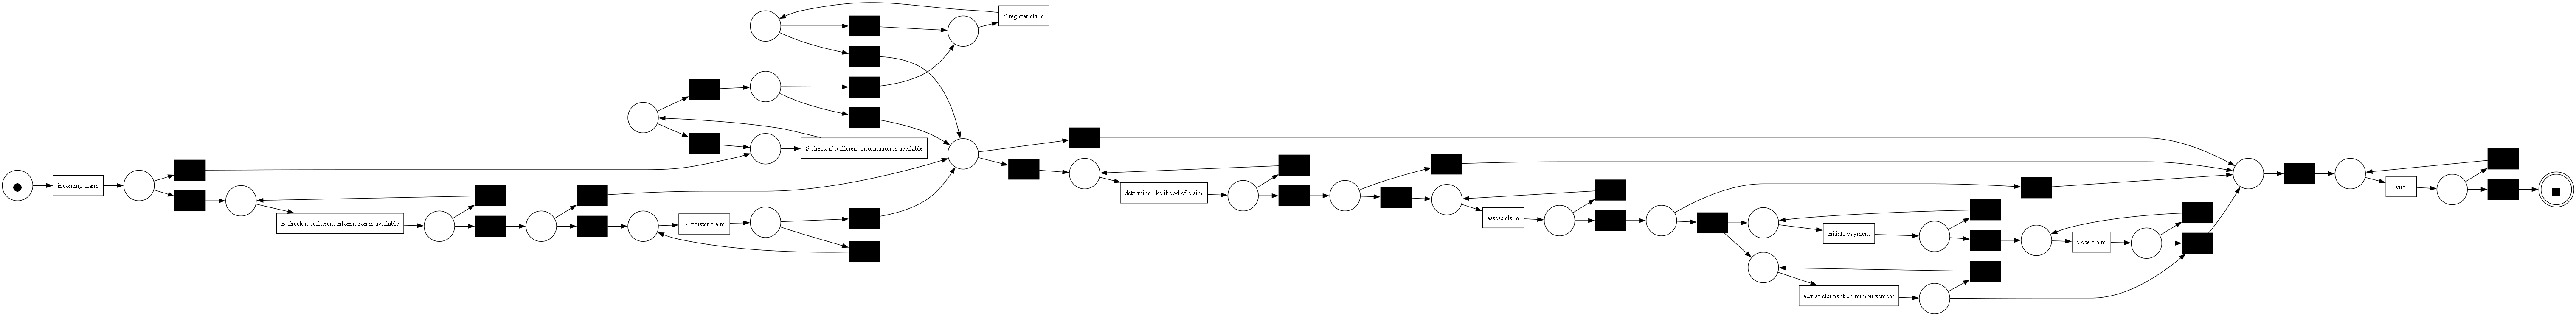

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 62.0, 'average_trace_fitness': 0.9845138981534918, 'log_fitness': 0.982964655124547, 'percentage_of_fitting_traces': 62.0}


replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

Generalization: 0.84789970122901


replaying log with TBR, completed traces ::   0%|          | 0/80 [00:00<?, ?it/s]

Precision:  0.4875846501128668


computing precision with alignments, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

Precision (Alignment-based):  0.4875846501128668


In [25]:
net, im, fm = pm4py.discover_petri_net_inductive(log_pm4py)

pm4py.view_petri_net(net, im, fm)

print("Fitness: ", pm4py.conformance.fitness_token_based_replay(generated_log_pm4py, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(generated_log_pm4py, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(generated_log_pm4py, net, im, fm))
print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(generated_log_pm4py, net, im, fm))